Imagine you were assigned a new job role and you were asked by your `CTO` to build a predictive model for credit scoring. To this end you have been tasked to find clues in the data to ascertain the following:
<li> What risk factors can be addressed
<li> If future cases can be predicted, interpret predictions on a case-by-case basis.
    
## Details about Loan Prediction
Before we dive into the data,we must gather some important details about Credit Scoring in order to do the following:
<li> Understand the problem's context and relevance.
<li> Extract domain knowledge information that can inform our data analysis and model interpretation.
<li> Relate an expert-informed background to a dataset's features.
    
## Approach
Logistic regression is one common way to rank risk factors in financial use cases. Unlike linear regression, It doesn't try to predict a continuous value for each of your observations, but it predicts a probability score that an observation belongs to a particular class. In this case, what we are trying to predict is, given x data for each loan applicant, what is the probability, from 0 to 1, that they will defaul on loan repayment.


## Loading the libraries
You will need to install the following libraries:
pandas and numpy to manipulate the dataset
statsmodels to fit the logistic regression model
sklearn to split the data
matplotlib to visualize the interpretations



In [3]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Understanding and preparing the data
The data used in the tutorial will be loaded into a dataframe, I call `credit_df`

In [4]:
credit_df = pd.read_csv('CreditScoring.csv')
credit_df.shape

(4455, 14)

From this, I was getting 4455 records and 14 columns. We can take a peek at what was loaded with `info()`. The command will output the names of each column with its typw and how many non-null records it contains:

In [5]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
Status       4455 non-null int64
Seniority    4455 non-null int64
Home         4455 non-null int64
Time         4455 non-null int64
Age          4455 non-null int64
Marital      4455 non-null int64
Records      4455 non-null int64
Job          4455 non-null int64
Expenses     4455 non-null int64
Income       4455 non-null int64
Assets       4455 non-null int64
Debt         4455 non-null int64
Amount       4455 non-null int64
Price        4455 non-null int64
dtypes: int64(14)
memory usage: 487.4 KB


In [6]:
credit_df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## Data Preparation
For the sake of interpretability and model performance, there are several data preparation tasks that we can take care of, but the one that stands out right now is `age`. In fact, for credit scoring and loan predictions like this one, we might even want to bucket them into age groups since people tend to age differently.

## Quantile binning
Quantiles are values that divide the data into equal portions. For example, the median divides the data in halves; half the data points are smaller and half larger than the median. The quantiles divide the data into quarters, the deciles into tenths, etc.


In [7]:
deciles = credit_df['Age'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
deciles

0.1    24.0
0.2    27.0
0.3    30.0
0.4    32.0
0.5    36.0
0.6    39.0
0.7    42.0
0.8    47.0
0.9    53.0
Name: Age, dtype: float64

Visualizing the deciles on the histogram

Text(0.5, 0, 'Age')

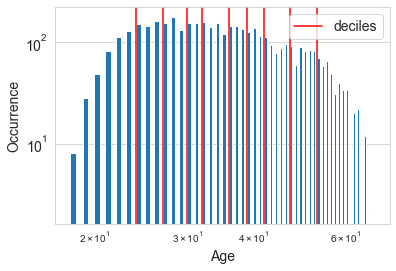

In [8]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
credit_df['Age'].hist(ax=ax, bins=100)

for pos in deciles:
    handle = plt.axvline(pos, color='r')
ax.legend([handle], ['deciles'], fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=14)
ax.set_ylabel('Occurrence', fontsize=14)
ax.set_xlabel('Age', fontsize=14)

To compute the decile and map data into decile bins, we can use the Pandas library.

In [9]:
# Map the counts to decile
age_bin = pd.qcut(credit_df['Age'], 10, labels=False )

age_series = pd.Series(age_bin)
age_series.quantile([0.25, 0.5, 0.75])
credit_df['bin_age'] = age_series

This is an example of feature engineering, which is when you use domain knowledge of your data to create features that better represent your problem, thereby improving the models. In subsequent blog post I'll write on `Feature Selection and engineering for interpretability` and also I'll look at `Monotonic Constraints and Model Tuning for interpretability`

Now we are going to take a peak at what the summary statistics are for each one of our features using the described() method:

In [10]:
credit_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Status,4455.0,1.281257e+00,4.501621e-01,0.0,1.0,1.0,2.0,2.0
Seniority,4455.0,7.987205e+00,8.173444e+00,0.0,2.0,5.0,12.0,48.0
Home,4455.0,2.657015e+00,1.610467e+00,0.0,2.0,2.0,4.0,6.0
Time,4455.0,4.644175e+01,1.465523e+01,6.0,36.0,48.0,60.0,72.0
Age,4455.0,3.707767e+01,1.098486e+01,18.0,28.0,36.0,45.0,68.0
Marital,4455.0,1.879012e+00,6.437478e-01,0.0,2.0,2.0,2.0,5.0
Records,4455.0,1.173513e+00,3.787326e-01,1.0,1.0,1.0,1.0,2.0
Job,4455.0,1.675870e+00,9.540352e-01,0.0,1.0,1.0,3.0,4.0
Expenses,4455.0,5.556880e+01,1.951588e+01,35.0,35.0,51.0,72.0,180.0
Income,4455.0,7.633170e+05,8.703625e+06,0.0,80.0,120.0,166.0,99999999.0


This shows the summary statistics outputted by the preceding code. `age` is looking good because it ranges between 18 and 68 years, which is not out of the ordinary, but there are some anomalous outliers for debt, assets and income. These outlier has to be removed because they could lead to poor model performance and interpretability.

In [11]:
credit_df = credit_df[(np.abs(stats.zscore(credit_df)) < 3).all(axis=1)]
credit_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Status,4066.0,1.270044,0.444591,0.0,1.00,1.0,2.00,2.0
Seniority,4066.0,7.604279,7.486212,0.0,2.00,5.0,12.00,32.0
Home,4066.0,2.679292,1.609000,1.0,2.00,2.0,5.00,6.0
Time,4066.0,46.565667,14.664254,6.0,36.00,48.0,60.00,72.0
Age,4066.0,36.568372,10.880153,18.0,28.00,35.0,44.00,68.0
Marital,4066.0,1.781358,0.449854,0.0,2.00,2.0,2.00,3.0
Records,4066.0,1.164781,0.371029,1.0,1.00,1.0,1.00,2.0
Job,4066.0,1.653960,0.944476,0.0,1.00,1.0,3.00,4.0
Expenses,4066.0,55.466306,18.561569,35.0,35.00,52.0,73.00,114.0
Income,4066.0,129.380964,83.130883,0.0,80.00,120.0,163.00,905.0


Now, in order to fit a logistic regression model, we must put all objective and subjective features together as X and the target feature alone as y. After this, you split the X and y into training and test datasets, but I made sure to include random_state for reproducibility:

In [12]:
credit_df['Status'] = credit_df['Status'].map(lambda x: 1 if x == 2 else 0)
y = credit_df['Status']
X = credit_df.drop(['Status'], axis=1).copy()
X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=0.20, random_state=41)

We will fit the model using the training data and print a summary of the results:


In [13]:

log_model = sm.Logit(y_train, sm.add_constant(X_train))
log_result = log_model.fit()
print(log_result.summary2()) # Printing summary2() on the fitted model produces the following output

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.433324
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.256      
Dependent Variable: Status           AIC:              2848.3414  
Date:               2021-08-30 10:43 BIC:              2939.6468  
No. Observations:   3252             Log-Likelihood:   -1409.2    
Df Model:           14               LL-Null:          -1894.7    
Df Residuals:       3237             LLR p-value:      2.4645e-198
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const         -2.6871    0.6542   -4.1074  0.0000  -3.9693  -1.4049
Seniority     -0.1026    0.0093  -11.0048  0.0000

The preceding summary helps us to understand which X features contributed the most to the y credit scoring using the model coefficients (labeled Coef. in the table). Much like with linear regression, they are like a weight applied to every predictor. However, the linear combination exponent is a logistic function. This makes the interpretation more difficult. I'll explain this in my next article  on Interpretation Challenges.

We can tell by looking at it that the features with the absolute highest values are  `Marital` and `Seniority`.






In [14]:
np.exp(log_result.params).sort_values(ascending=False)

Records      5.749854
Job          1.286166
Expenses     1.021551
Home         1.012364
bin_age      1.005354
Time         1.003949
Amount       1.002316
Debt         1.000146
Assets       0.999944
Age          0.998820
Price        0.998535
Income       0.990905
Seniority    0.902500
Marital      0.662799
const        0.068079
dtype: float64

The question we need to ask is why the exponential? The coefficients are the log odds, which are the logarithms of the odds. Also, odds are the probability of a positive case over the probability of a negative case, where the positive case is the phenomenon we are trying to predict. 

Back to our credit scoring case. Now that we have the odds, we can interprete what it means. For example, what do the odds mean in the case of being married? It means that the odds of credit scoring increases by a factor of 1.51 for each additional unit of being married, provided every other feature stays unchanged. Being ableo explain the impact of a feature on the model in such tangible terms is one of the advantages of an `intrinsically interpretable` model such as logistic regression

Although the `odds` provide us with useful information, they don't tell us what matters the most and, therefore, by themselves, cannot be used to measure feature importance. But how could that be? If something has higher odds, then it must matter more, right? Well for starters, they all have different scales, so that makes a huge difference. This is because if you are to measure the odds of how nuch something increases, you have to know by how much it typically increases because that provides context. For example, we could say that the odds of an applicant being granted a loan is 0.66 after their first loan is given to them. This statement is meaningless to you unless you know the net worth of the applicant's income and the applicants credit score history.

To provide context to our odds, we can easily calculate the standard deviation of our features using the `np.std` function:


In [15]:
np.std(X_train, 0)

Seniority       7.487746
Home            1.621719
Time           14.611755
Age            10.851184
Marital         0.447501
Records         0.370741
Job             0.951558
Expenses       18.415899
Income         79.682088
Assets       9639.626236
Debt         1229.140925
Amount        420.564135
Price         486.766477
bin_age         2.931092
dtype: float64

As you can tell by the output, ordinal features can only typically vary by one at most, but continuous features, such as `Assets`and `Debt` can vary 100 - 1000 times more, as evidenced by the standard deviation of the features. 

Another reason why `odds` cannot be used tomeasure feature importance is because despite favourable odds, sometimes features are not statisticall significant. They are entangled with other features in such a way they might appear to be significant, but we can prove that they aren't. If the `p-value` is less than 0.05, it means that there is a strong evidence that the feature is significant. However, when it's above 0.05, especially by a large margi, there is no statistical evidence thatit affects the predicted score. Such is the case with `Home`, `Time`, `Age`, `bin_age` at least in this dataset.

If we are trying to obtain what features matters most, one way to approximate this is to multiply the coefficients by the standard deviations of the features. Incoporating the standard deviations accounts for differences in variances between features. Hence, it is better if we get `Home`, `Time`, `Age`, `bin_age` out of the way too while we are at it:

In [16]:
coefs = log_result.params.drop(labels=['const', 'Home', 'Time', 'Age', 'bin_age'])
stdv = np.std(X_train, 0).drop(labels=['Home', 'Time', 'Age', 'bin_age'])
abs(coefs * stdv).sort_values(ascending=False)

Amount       0.973035
Seniority    0.768144
Income       0.728014
Price        0.713635
Records      0.648491
Assets       0.541689
Expenses     0.392673
Job          0.239474
Marital      0.184050
Debt         0.179711
dtype: float64

The preceding table can be interpreted as an `approximation of risk factors` from high to low according to the model. It is also a `model specific` feature importance method, in other words, a global model(modular) interpretation method. There's a lot of new concepts to unpack here so let's break them down.


There are two model interpretability method types:
<li> <b>Model-specific:</b> When the method can only be used for a specific model class, then it's model-specific.
<li> <b>Model-agnostic:</b> These are methods that can work with any model class.

## Model Interpretability scopes

There are several model interpretability scopes:
<li><b>Global holistic interpretation:</b> You can explain how a model makes predictions simply because you can comprehend the entire model at once with a complete understanding of the data, and it's a trained model.</li>
    
<li><b>Global modular interpretation:</b> In the same way that you can explain the role of parts of an internal combustion engine in the `whole` process of turning fuel into movement, you can also do so with a model. For instance, in the credit scoring risk factor example, our feature importance method tells us that `Amount`, `Seniority`, `Income` and `Price` are the parts that impact the `whole` the most. Feature importance is only one of many global modular interpretation methods but arguably the most important one. My subsequent articles goes into model detail on feature importance.   </li>

<li><b>Local single-prediction interpretation:</b> You can explain why a single prediction was made. The next example will illustrate this concept. </li>

<li><b>Local group-prediction interpretation:</b> The same as single-prediction, except that it applies to groups of predictions.

Congratulations! You've already determined the risk factors with a global model interpretation method, but the `CTO` of your company also want you to know whether the model can be used to interpret individual cases. So, we'll look into that in my next article. Be on the watch for the next article on  local single-prediction interpretation and local group-prediction interpretation. 

Thank you!!!

## Local Single Prediction Interpretation of a Credit Scoring Model

Since, we are starting off with the same credit score dataset we used in the article on global inerpretation of credit score model using logistic regression.

The same jupyter notebook was used in writing the code and interpreting the analysis.


### Interpreting individual predictions with logistic regression

Now, what if we used the model to predict loan eligibility for the entire test dataset? You could do so like this:


In [17]:
y_pred = log_result.predict(sm.add_constant(X_test)).to_numpy()
print(y_pred)
# The resulting array is the probabilities that each test case is positive for loan status.

[3.98275572e-01 1.98240630e-01 2.25906902e-01 6.49470219e-02
 1.05605018e-01 1.72528291e-01 6.25025302e-01 3.63273821e-01
 2.80129025e-02 6.90233673e-01 5.98813198e-02 1.21831960e-01
 6.11058326e-01 3.66729808e-01 3.82376190e-01 3.71960507e-01
 1.23565753e-01 5.52225484e-01 2.40564811e-01 4.58197600e-02
 3.04451741e-01 1.91558761e-01 2.15817019e-01 1.32479975e-01
 9.41152353e-02 4.35236799e-01 3.58360777e-01 4.54783574e-01
 6.72144213e-02 5.31428862e-01 2.35594095e-01 3.97296691e-01
 2.89817092e-01 2.72480278e-02 4.01312720e-01 1.23584388e-01
 9.57974750e-03 1.27911969e-01 9.56506451e-03 2.50728489e-01
 5.31461408e-01 5.27506828e-02 2.09524877e-01 6.61291728e-01
 1.43773120e-02 2.44638399e-02 2.84920897e-01 5.45195903e-02
 1.94639372e-01 3.27445773e-02 2.22178910e-01 3.34851317e-01
 5.03868853e-01 1.72700129e-01 8.32502379e-01 2.28384592e-02
 8.30769941e-01 1.56196812e-02 3.77027169e-02 1.10662427e-01
 3.23308429e-01 2.80643205e-01 6.27654646e-02 1.73758558e-01
 3.10141686e-01 3.811575

Let's take one of the positive cases; test case #542:

In [51]:
print(y_pred[542])
# We know that it predicted positive for loan status.

0.6782734647265871


In [52]:
print(X_test.iloc[542])

# The following is the output:

Seniority       1
Home            5
Time           36
Age            28
Marital         2
Records         2
Job             1
Expenses       60
Income         95
Assets       4000
Debt            0
Amount        500
Price         625
bin_age         2
Name: 1654, dtype: int64


So, by the looks of the preceding series, we know that the following applies to this individual:
1. It seems this individual does have any debt/
3. Assets is okay. It shows this individual is capable of paying the loan.
4. Marital of 2. Shows this person is married.
5. Expenses is okay when compared to the person's income.

But how do we put everything in context at the same time? We can't possibly visualize how one prediction compares with other ten thousand for every single feature and their respective loan status. Unfortunately, humans can't process that level of dimensionality, even if it were possible to visualize a twenty-dimensional hyperplane!

This graphical interpretation method is what is termed a `decision boundary`. It draws boundaries for the classes, leaving areas that belong to one class or another. Such areas are called `decision regions`. In this case, we had three classes but we transformed the data to a two class problem, so we will see a graph with a single boundary between `status=0` and `status=1`, only concerning the two features we are comparing.

In [53]:
credit_df.loc[(credit_df['Age'] == 30)].describe()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price,bin_age
count,146.000000,146.000000,146.000000,146.000000,146.0,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.0
mean,0.267123,5.582192,2.801370,47.219178,30.0,1.780822,1.198630,1.568493,53.095890,123.465753,3164.897260,439.164384,1040.616438,1425.554795,2.0
std,0.443980,4.836295,1.724548,15.602605,0.0,0.415114,0.400342,0.870256,15.835067,72.928039,4559.844011,1001.663795,422.834805,484.811076,0.0
min,0.000000,0.000000,1.000000,6.000000,30.0,1.000000,1.000000,1.000000,35.000000,0.000000,0.000000,0.000000,200.000000,425.000000,2.0
25%,0.000000,2.000000,2.000000,36.000000,30.0,2.000000,1.000000,1.000000,35.000000,80.000000,0.000000,0.000000,750.000000,1065.250000,2.0
50%,0.000000,4.000000,2.000000,60.000000,30.0,2.000000,1.000000,1.000000,48.000000,111.000000,2000.000000,0.000000,1000.000000,1375.500000,2.0
75%,1.000000,9.000000,5.000000,60.000000,30.0,2.000000,1.000000,2.000000,60.000000,165.000000,4500.000000,46.500000,1300.000000,1715.500000,2.0
max,1.000000,16.000000,6.000000,60.000000,30.0,2.000000,2.000000,4.000000,105.000000,350.000000,30000.000000,5500.000000,2000.000000,2750.000000,2.0


For instance, `age=30` is the least risky value of those present in the dataset for age. 
Let's come up with optimal values for the remainder of the features:
<li>Seniority=5</li>
<li>Home=3</li>
<li>Time=47</li>
<li>Marital=1</li>
<li>Records=1</li>
<li>Jobs=1</li>
<li>Expenses=53</li>
<li>Income= 123 (Optimal for that age)</li>
<li>Assets=3164</li>
<li>Debt=439</li>
<li>Amount=1040</li>
<li>Price= 1425</li>
<li>bin_age= 2</li>

In [54]:
filler_feature_values = {0:1, 1:5, 2:3, 3:47, 4:30, 5:1, 6:1, 7:1, 8:53, 9:123, 10:3164, 11:439, 12:1040, 13:1425, 14:2}



In the dictionary, the features are numbered and not named because the function we will use to plot the decision regions only takes in Numpy arrays. Also, since in `statsmodel`, you must explicitly define the `constant`, the logistic model has an additional 0 feature, which always equals 1.


We also intend to plot the actual predictions for the test dataset. To dothis we must define another dictionary like `filler_feature_values`

In [55]:
filler_feature_ranges = {0:1, 1:4, 2:3, 3:13, 4:35, 5:1, 6:1, 7:1, 8:53, 9:220, 10:26000, 11:5000, 12:900, 13:700, 14:1}

The next thing to do is to create a (1, 15) shaped NumPy array with test case #547 so that the plotting function can highlight it. We first convert it to NumPy and then prepend the `constant` of 1, which must be the first feature, and then reshape it so that it meets the (1, 15) dimensions:

In [56]:
X_highlight = np.reshape(\
                        np.concatenate(([1], X_test.iloc[542].to_numpy())), (1, 15))

print(X_highlight)

[[   1    1    5   36   28    2    2    1   60   95 4000    0  500  625
     2]]


We are good to go now! Let's visualize some decision region plots! We will compare the feature that is thought to be the highest <i>risk factor</i>, `Amount`, with the following four most important risk factors: `Seniority`, `Income`, `Price`, and `Record`.

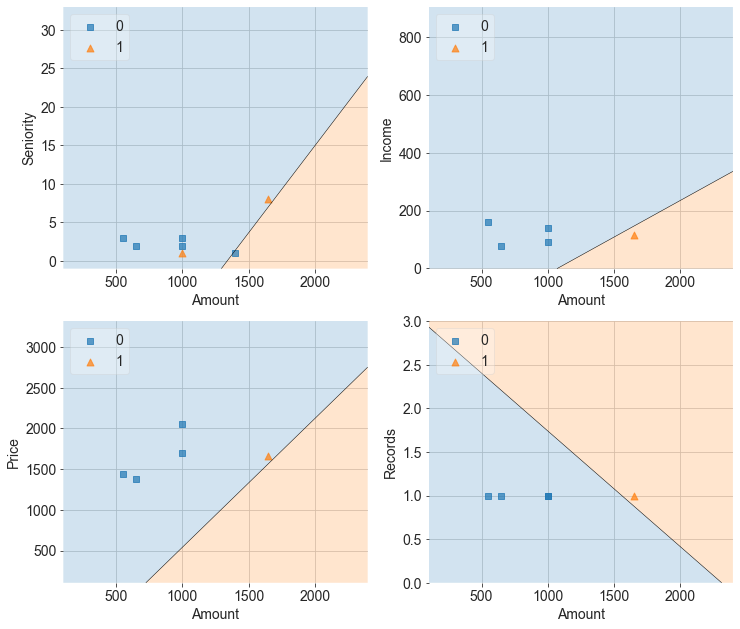

In [64]:
# Import the mlxtend package and then import 'plot_decision_regions method'
from mlxtend.plotting import plot_decision_regions
plt.rcParams.update({'font.size': 14})
fig, axarr = plt.subplots(2, 2, figsize=(12, 8), sharex=True, \
    sharey=False)

# Create Decision Surface Plot based on a 2D Interaction
def create_decision_plot(X, y, model, feature_index, feature_names, X_highlight, filler_feature_values, filler_feature_ranges, ax=None):
    filler_values = dict((k, filler_feature_values[k]) for k in filler_feature_values.keys() if k not in feature_index)
    filler_ranges = dict((k, filler_feature_ranges[k]) for k in filler_feature_ranges.keys() if k not in feature_index)
    ax = plot_decision_regions(sm.add_constant(X).to_numpy(), y.to_numpy(), clf=model, 
                                feature_index=feature_index,
                                X_highlight=X_highlight,
                                filler_feature_values=filler_values,
                                filler_feature_ranges=filler_ranges,
                                scatter_kwargs={'s':48, 'edgecolor':None, 'alpha':0.7},
                                contourf_kwargs = {'alpha': 0.2}, legend=2, ax=ax)
    
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    return ax

create_decision_plot(X_test, y_test, log_result, [12, 1], ['Amount', 'Seniority'], X_highlight, filler_feature_values, filler_feature_ranges, ax=axarr.flat[0])
create_decision_plot(X_test, y_test, log_result, [12, 9], ['Amount', 'Income'], X_highlight, filler_feature_values, filler_feature_ranges, ax=axarr.flat[1])
create_decision_plot(X_test, y_test, log_result, [12, 13], ['Amount', 'Price'], X_highlight, filler_feature_values, filler_feature_ranges, ax=axarr.flat[2])
create_decision_plot(X_test, y_test, log_result, [12, 6], ['Amount', 'Records'], X_highlight, filler_feature_values, filler_feature_ranges, ax=axarr.flat[3])

plt.subplots_adjust(top=1, bottom=0, hspace=0.2, wspace=0.2)
plt.show()

In [60]:
fig.savefig('decision_plot')

### Appreciating what hinders machine learning interpretability
Looking at the plot we noticed that the chart of Loan_Amount and other features showed a conclusive pattern. Sometimes you will encounter critical meditiating variables that could explain the increased risk of loan default.
N.B: A `mediating variable` is one that influences the strength between the independent and target (dependent) variable.  


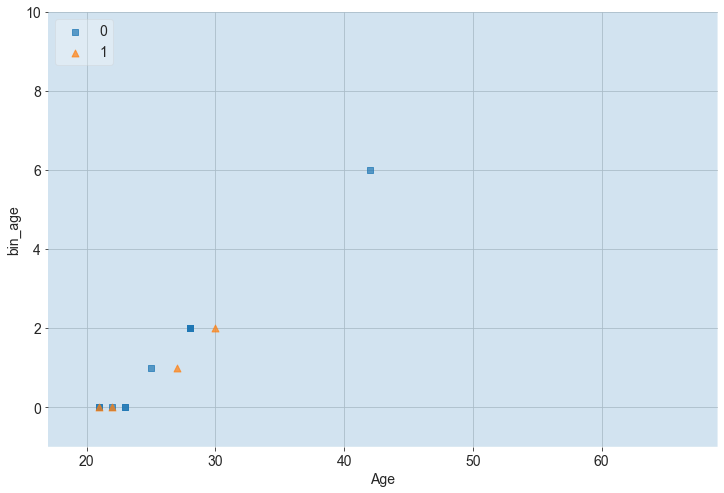

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
create_decision_plot(X_test, y_test, log_result,[4, 14], ['Age', 'bin_age'], X_highlight, filler_feature_values, filler_feature_ranges, ax=ax)
plt.show()

No decision boundary was ascertained in the chart above because if all variables are held constant (at less risky value), no age and age group combination is enough to predict loan default.

Dimensionality aside, there are chiefly three things that introduce complexity that makes interpretation difficult.
1. Non-linearity
2. Interactivity
3. Non-monotonicity


### Non-linearity
Linear equations are additive, it is easy to separate the effects of each of its terms from the outcome of the model. This is why we say machine learning models such as linear/ logistic regressions are very interpretable. 

Note that, there are model classes that are inherently non-linear because they introduce non-linearity in their training. deep learning models like neural networks are non-linear because they have non-linear activation functions such as `sigmoid`. Logistic regression is considered a generalized linear model because it's additive. 

Please note that even if your model is linear, the relationships between the variables may howvere not be linear, which can invariably lead to poor performance and interpretability.

How can we avert this? 
We can avert this by adopt either of the following approaches:
1. Use a non-linear model class
2. Use domain knowledge to engineer a feature that can help "linearize" it
3. Identify outliers and eliminate them.


### Interactivity

When we create a feature that has an interaction between two independent variables in the feature space. Interaction feature could be informed by domain knowledge. Note that many model classes do this interaction automatically by permutating all kinds of operations between features. Features have `latent` relationships between one another. You can automate the process of looking for interaction. This is usually the case for many deep learning problems where the data is unstructured and, therefore, part of the task of training the model is looking for the latent relationships that `don't mean anything`(which is called a `spurious relationship or correlation`).

### Non-monotonicity

A variable has a meaningful and consistent relationship between a feature and the target variable. So, we know that as `income` and `Asset` increases, the risk of defaulting is low. There is no point at which you reach a certain income and this risk rises. Maybe the risk slowly rises up but it doesn't rise abruptly. We call this `monotonicity`, and functions that are `monotonic` are either always increasing or decreasing throughout their entire domain.

Note that `all` linear relationships are monotonic, but not all monotonic relationships are necessarily linear.
A model doesn't know about a monotonic relationship that we expect because of our domain expertise. Then because of noise and omissions in the data, the model is trained in such a way in which there are ups and downs where you don't expect them.
Some model classes are inherently monotonic, such as logistic regression, so they can't have this problem, but many others do. 
I will explain this in my subsequent blog post on `Monotonic Constraints and Model Tuning for Interpretability`

### REFERENCES
1. Mlextend Documentation, Plotting Decision Regions. http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/ 
2. Molnar, Christoph. Interpretable Machine Learning. A Guide for Making Black Box Models Explainable, 2019: https://christophm.github.io/interpretable-ml-book/

3. Serg Masis. Interpretable Machine Learning with Python 
